In [23]:
import numpy as np
import pymc as pm
from scipy import stats
import matplotlib.pyplot as plt
from typing import Optional, Tuple
from tqdm import trange

class StudentTProcess:
    def __init__(self, 
                 nu_alpha: float = 2, 
                 nu_beta: float = 0.1,
                 ls_alpha: float = 2, 
                 ls_beta: float = 1,
                 amp_sigma: float = 1.0,
                 noise_sigma: float = 1.0):
        """
        Initialize Student-t Process
        
        Parameters:
        -----------
        nu_alpha, nu_beta : float
            Shape and rate parameters for Gamma prior on degrees of freedom
        ls_alpha, ls_beta : float
            Shape and rate parameters for Gamma prior on lengthscale
        amp_sigma : float
            Scale parameter for Half-Normal prior on amplitude
        noise_sigma : float
            Scale parameter for Half-Normal prior on noise
        """
        self.nu_alpha = nu_alpha
        self.nu_beta = nu_beta
        self.ls_alpha = ls_alpha
        self.ls_beta = ls_beta
        self.amp_sigma = amp_sigma
        self.noise_sigma = noise_sigma
        self.trace = None
        self.model = None
        
    def build_model(self, X: np.ndarray, y: Optional[np.ndarray] = None) -> pm.Model:
        """Build PyMC model for Student-t Process"""
        X = X.reshape(-1, 1)
        
        with pm.Model() as model:
            # Hyperparameters
            nu = pm.Gamma("nu", alpha=self.nu_alpha, beta=self.nu_beta)
            ls = pm.Gamma("lengthscale", alpha=self.ls_alpha, beta=self.ls_beta)
            amp = pm.HalfNormal("amplitude", sigma=self.amp_sigma)
            noise = pm.HalfNormal("noise", sigma=self.noise_sigma)
            
            # Kernel with diagonal noise
            cov_func = (
                amp**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ls) + 
                pm.gp.cov.WhiteNoise(noise)
            )
            
            # Compute covariance matrix
            K = cov_func(X)
            
            # Student-t likelihood
            if y is not None:
                y_obs = pm.MvStudentT(
                    "y_obs",
                    nu=nu,
                    mu=np.zeros(len(X)),
                    scale=K,
                    observed=y
                )
                
        self.model = model
        return model
    
    def fit(self, X: np.ndarray, y: np.ndarray, 
            draws: int = 1000, tune: int = 1000) -> None:
        """Fit the Student-t Process to data"""
        self.build_model(X, y)
        with self.model:
            self.trace = pm.sample(draws, tune=tune, return_inferencedata=True, chains=2, nuts_sampler='numpyro')

    def fast_predict(self, X_new: np.ndarray, X_train: np.ndarray, 
                    y_train: np.ndarray) -> Tuple[np.ndarray, np.ndarray, float]:
        """
        Quick prediction using mean posterior parameters (not fully Bayesian)
        
        Parameters:
        -----------
        X_new : array
            Points at which to predict
        X_train : array
            Training inputs
        y_train : array
            Training outputs
        
        Returns:
        --------
        mu_star : array
            Predictive mean
        K_pred : array
            Predictive covariance
        nu_pred : float
            Posterior degrees of freedom
        """
        if self.trace is None:
            raise ValueError("Model must be fit before making predictions")
            
        X_new = X_new.reshape(-1, 1)
        X_train = X_train.reshape(-1, 1)
        
        # Get mean posterior parameter values
        nu = float(self.trace.posterior['nu'].mean())
        ls = float(self.trace.posterior['lengthscale'].mean())
        amp = float(self.trace.posterior['amplitude'].mean())
        noise = float(self.trace.posterior['noise'].mean())
        
        # Compute kernels
        cov_func = (
            amp**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ls) + 
            pm.gp.cov.WhiteNoise(noise)
        )
        
        K_train = cov_func(X_train).eval()
        K_star = cov_func(X_new, X_train).eval()
        K_starstar = cov_func(X_new).eval()
        
        # Compute predictive parameters
        K_inv = np.linalg.inv(K_train)
        beta = y_train.T @ K_inv @ y_train
        
        mu_star = K_star @ K_inv @ y_train
        
        n = len(X_train)
        scale_factor = (nu + beta - 2)/(nu + n - 2)
        K_pred = scale_factor * (K_starstar - K_star @ K_inv @ K_star.T)
        
        return mu_star, K_pred, nu + n

    def predict(self, X_new: np.ndarray, X_train: np.ndarray, 
                y_train: np.ndarray, n_samples: int = 1000) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Compute posterior predictive distribution for new input points
        
        Parameters:
        -----------
        X_new : array
            Points at which to predict
        X_train : array
            Training inputs
        y_train : array
            Training outputs
        n_samples : int
            Number of posterior samples to use
        
        Returns:
        --------
        mean_pred : array
            Mean of predictions
        lower : array
            Lower 95% credible interval
        upper : array
            Upper 95% credible interval
        """
        if self.trace is None:
            raise ValueError("Model must be fit before making predictions")
            
        X_new = X_new.reshape(-1, 1)
        X_train = X_train.reshape(-1, 1)
        
        # Store predictions
        post_samples = []
        
        # Sample from posterior predictive
        for idx in trange(n_samples):
            # Get random sample from posterior
            sample_idx = np.random.randint(len(self.trace.posterior['nu']))
            chain_idx = np.random.randint(len(self.trace.posterior['nu'].chain))
            
            nu = float(self.trace.posterior['nu'][chain_idx, sample_idx])
            ls = float(self.trace.posterior['lengthscale'][chain_idx, sample_idx])
            amp = float(self.trace.posterior['amplitude'][chain_idx, sample_idx])
            noise = float(self.trace.posterior['noise'][chain_idx, sample_idx])
            
            # Compute kernels with these parameters
            cov_func = (
                amp**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ls) + 
                pm.gp.cov.WhiteNoise(noise)
            )
            
            K_train = cov_func(X_train).eval()
            K_star = cov_func(X_new, X_train).eval()
            K_starstar = cov_func(X_new).eval()
            
            # Compute predictive parameters
            K_inv = np.linalg.inv(K_train)
            beta = y_train.T @ K_inv @ y_train
            
            mu_star = K_star @ K_inv @ y_train
            
            n = len(X_train)
            scale_factor = (nu + beta - 2)/(nu + n - 2)
            K_pred = scale_factor * (K_starstar - K_star @ K_inv @ K_star.T)
            
            # Sample from multivariate t distribution
            pred = stats.multivariate_t.rvs(
                df=nu + n,
                loc=mu_star.ravel(),
                shape=K_pred,
                size=1
            )
            post_samples.append(pred)
        
        post_samples = np.array(post_samples)
        
        # Return mean and quantiles
        mean_pred = np.mean(post_samples, axis=0)
        lower = np.percentile(post_samples, 2.5, axis=0)
        upper = np.percentile(post_samples, 97.5, axis=0)
        
        return mean_pred, lower, upper

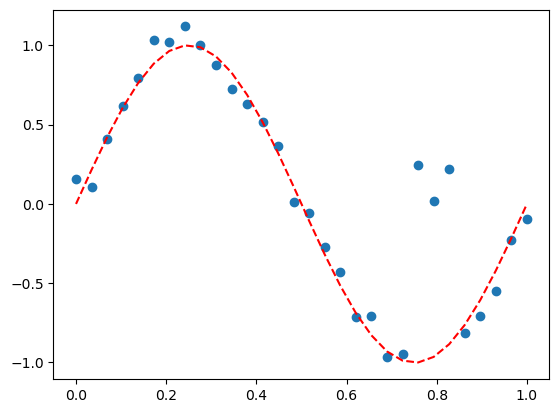

In [24]:
# Test script
def generate_synthetic_data(n_points=50, noise_level=0.1):
    """Generate synthetic data with Student-t noise"""
    X = np.linspace(-3, 3, n_points)
    true_f = np.sin(X) + 0.3 * X**2
    noise = noise_level * np.random.standard_t(df=3, size=n_points)
    y = true_f + noise
    return X, y, true_f

def true_function(X):
    """Compute true function values"""
    Y = np.sin(X)
    return Y/Y.max()

def plot_results(tp, X_train, y_train, true_func, fast=False):
    """Plot the results"""

    X_test = np.linspace(0.0, np.pi * 2, 100)
    X_test = X_test/X_test.max()
    
    if fast:
        mu, cov, nu = tp.fast_predict(X_test, X_train, y_train)
        std = np.sqrt(np.diag(cov))
        lower = mu.ravel() - 2*std
        upper = mu.ravel() + 2*std
        mean_pred = mu.ravel()
    else:
        mean_pred, lower, upper = tp.predict(X_test, X_train, y_train)
    
    plt.figure(figsize=(12, 6))
    plt.plot(X_test, mean_pred, 'b-', label='Predictive mean')
    plt.fill_between(X_test, 
                    lower,
                    upper,
                    color='b', alpha=0.2, 
                    label='95% credible interval')
    plt.scatter(X_train, y_train, c='k', alpha=0.5, label='Training data')
    plt.plot(X_test, true_func(X_test), 'r--', label='True function')
    plt.legend()
    plt.title('Student-t Process Regression')
    plt.show()

def generate_synthetic_data_alt(n_points=100, noise_std=0.1, outlier_magnitude=1.0, num_outliers=3):
    # Generate X values
    X = np.linspace(0.0, np.pi * 2, n_points)[:, None]
    Y = np.sin(X)
    
    # Normalize Y
    Y = Y / Y.max()
    
    # Create copy for corrupted version
    Yc = Y.copy()
    
    # Normalize X
    X = X / X.max()
    
    # Add outliers
    outlier_start = int(0.75*n_points)
    Yc[outlier_start:outlier_start+num_outliers] += outlier_magnitude
    Yc += np.random.randn(*X.shape) * noise_std
    
    return X, Y.reshape(-1), Yc.reshape(-1)


# Generate synthetic data
X_train, y_true, y_train = generate_synthetic_data_alt(n_points=30, noise_std=0.1, outlier_magnitude=1.0)

plt.plot(X_train, y_train, 'o')
plt.plot(X_train, y_true, 'r--')

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics


               mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
nu           20.791  13.466   1.594   45.465      0.360    0.255    1210.0   
noise         0.247   0.082   0.124    0.406      0.003    0.002     652.0   
lengthscale   0.129   0.074   0.049    0.275      0.004    0.003     533.0   
amplitude     0.703   0.262   0.305    1.169      0.008    0.006    1210.0   

             ess_tail  r_hat  
nu             1113.0    1.0  
noise          1023.0    1.0  
lengthscale    1135.0    1.0  
amplitude      1137.0    1.0  


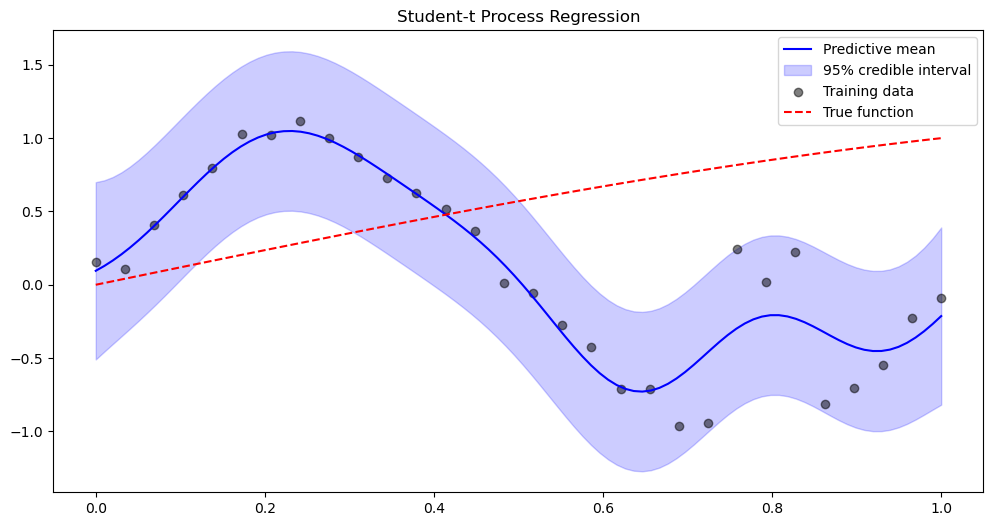

In [25]:

# Create and fit Student-t Process
tp = StudentTProcess()
tp.fit(X_train, y_train)

# Print summary of posterior
print(pm.summary(tp.trace, var_names=["nu", "noise", "lengthscale", "amplitude"]))

# Plot results
plot_results(tp, X_train, y_train, true_function, fast=True)

Quick Check

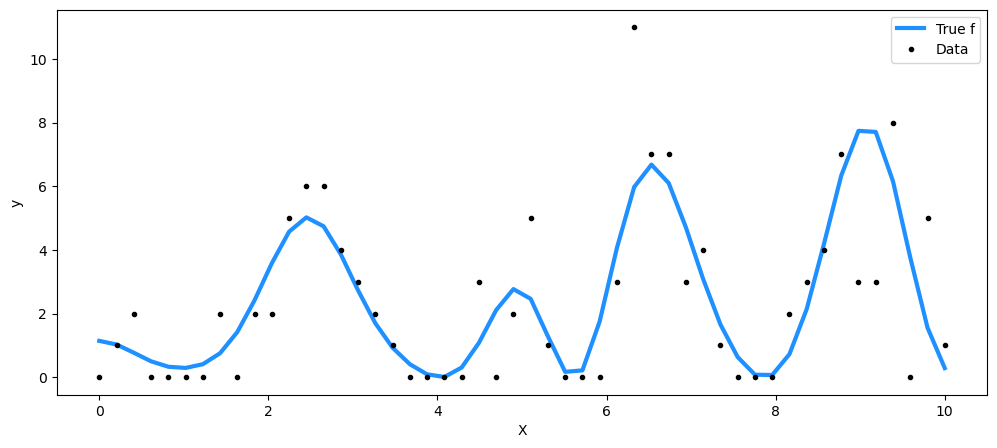

In [5]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt

from pymc.gp.util import plot_gp_dist

%matplotlib inline

np.random.seed(7)

n = 50  # The number of data points
X = np.linspace(0, 10, n)[:, None]  # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ell_true = 1.0
eta_true = 3.0
cov_func = eta_true**2 * pm.gp.cov.ExpQuad(1, ell_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = pm.draw(pm.MvStudentT.dist(mu=mean_func(X).eval(), scale=cov_func(X).eval(), nu=3), 1, random_seed=42)
y = np.random.poisson(f_true**2)

fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
ax.plot(X, f_true**2, "dodgerblue", lw=3, label="True f")
ax.plot(X, y, "ok", ms=3, label="Data")
ax.set_xlabel("X")
ax.set_ylabel("y")
plt.legend();

In [11]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=2)
    eta = pm.HalfCauchy("eta", beta=3)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ell)

    # informative prior on degrees of freedom < 5
    # nu = pm.Gamma("nu", alpha=2, beta=1)
    tp = pm.gp.Latent(cov_func=cov)
    f = tp.prior("f", X=X)

    pm.Poisson("y", mu=pt.square(f), observed=y)

    tr = pm.sample(target_accept=0.9, nuts_sampler="numpyro", chains=2)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [12]:
n_new = 200
X_new = np.linspace(0, 15, n_new)[:, None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = tp.conditional("f_pred", X_new)

# Sample from the GP conditional distribution
with model:
    pm.sample_posterior_predictive(tr, var_names=["f_pred"], extend_inferencedata=True)

Sampling: [f_pred]


Output()

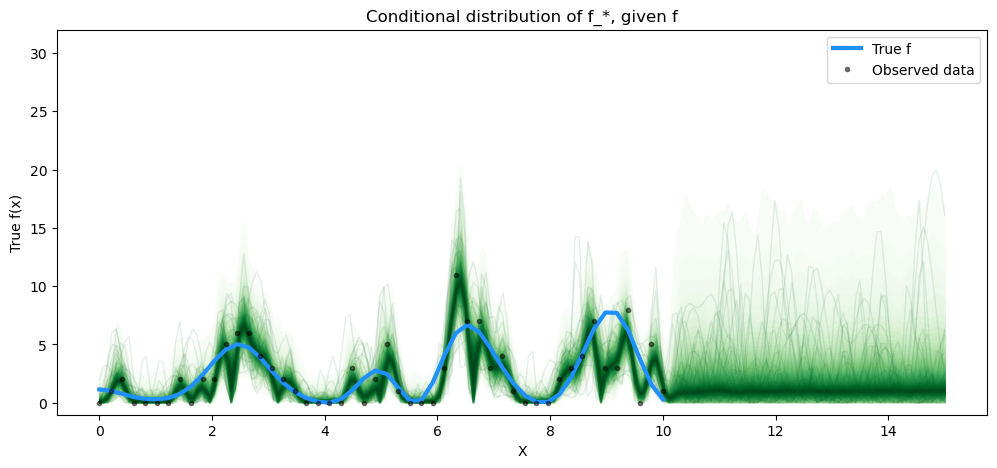

In [15]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

f_pred_samples = np.square(
    az.extract(tr.posterior_predictive).astype(np.float32)["f_pred"].values
).T
plot_gp_dist(ax, f_pred_samples, X_new, palette='Greens')
plt.plot(X, np.square(f_true), "dodgerblue", lw=3, label="True f")
plt.plot(X, y, "ok", ms=3, alpha=0.5, label="Observed data")
plt.xlabel("X")
plt.ylabel("True f(x)")
plt.title("Conditional distribution of f_*, given f")
plt.ylim(None, 32)
plt.legend();